In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import SelectKBest,f_regression
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost.sklearn import XGBRegressor 
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score

In [2]:
train = pd.read_csv('training.csv')
test = pd.read_csv('test_features.csv')

In [3]:
train.shape

(1000000, 10)

In [4]:
clean_df = train[train.salary > 0]
clean_df = clean_df.drop('jobId', axis = 1)
clean_df.shape

(999995, 9)

Building Data Frames for the models

In [5]:
feature_df = clean_df.drop('salary',axis = 1)
target = clean_df['salary']
job_id = test['jobId']
test = test.drop('jobId', axis = 1)

#### Building a ColumnTransformer
One Hot Encoding the categorical variables and passing the numerical values through. I am going to also build a dataframe just to show how many features we will have after one hot encoding

In [6]:
transformer = make_column_transformer(
(OneHotEncoder(), ['companyId','jobType',
            'degree','major','industry']),
            remainder = 'passthrough')

In [7]:
dummies = pd.get_dummies(feature_df, columns = ['companyId','jobType','degree','major','industry'])
dum = dummies.loc[:, ~dummies.columns.str.match('Unnamed')]
print(F"There are {len(dum.columns)} features after one hot encoding.")

There are 94 features after one hot encoding.


#### Baseline Model

In [8]:
avg = np.mean(target)
print(F"The average salary is ${avg:.2f}k")
print()
constant = [50,100,int(avg),150,200]
for con in constant:
    lst = [con]*len(target)
    mae = mean_absolute_error(target, lst)
    print(F"The MAE predicting only ${con}k is {mae:.5f}")

The average salary is $116.06k

The MAE predicting only $50k is 66.61364
The MAE predicting only $100k is 32.91118
The MAE predicting only $116k is 31.00767
The MAE predicting only $150k is 43.14076
The MAE predicting only $200k is 84.69683


The baseline models are calculating the mean absolute error between the target salaries and a constant value (50k, 100k, average, 150k & 200k). The best baseline model is to use the average salary of the target. The MAE is 31, meaning that a predicted salary of 116k is off by 31k. Not very good if we are to use this to bring in employees. Time to build some models to reduce the MAE and start hiring people!

### Linear Regression

In [9]:
model_lr = make_pipeline(transformer, LinearRegression())
mae_lr = cross_val_score(model_lr, feature_df, target, cv = 10, n_jobs = -1, scoring='neg_mean_absolute_error')
mean_mae_lr = -1 * np.mean(mae_lr)
cv_std_lr = np.std(mae_lr)
print(F"The 10-fold validation average MAE is {mean_mae_lr:.5f}, and the standard deviation is {cv_std_lr:.5f}")

The 10-fold validation average MAE is 15.84617, and the standard deviation is 0.04765


### How well does linear regression predict for a certain number of features? 
Well lets check that out! I will use Select K Best features with f regression to determine the best k features.

In [10]:
mae_feat = []
num_feat = []
for k in range(1,len(dum.columns)+1):
    model = make_pipeline(transformer, SelectKBest(f_regression, k = k), LinearRegression())
    mae = cross_val_score(model, feature_df, target, cv = 5, n_jobs = -1, scoring='neg_mean_absolute_error')
    mean_mae = -1 * np.mean(mae)
    cv_std = np.std(mae)
    mae_feat.append(mean_mae)
    num_feat.append(k)

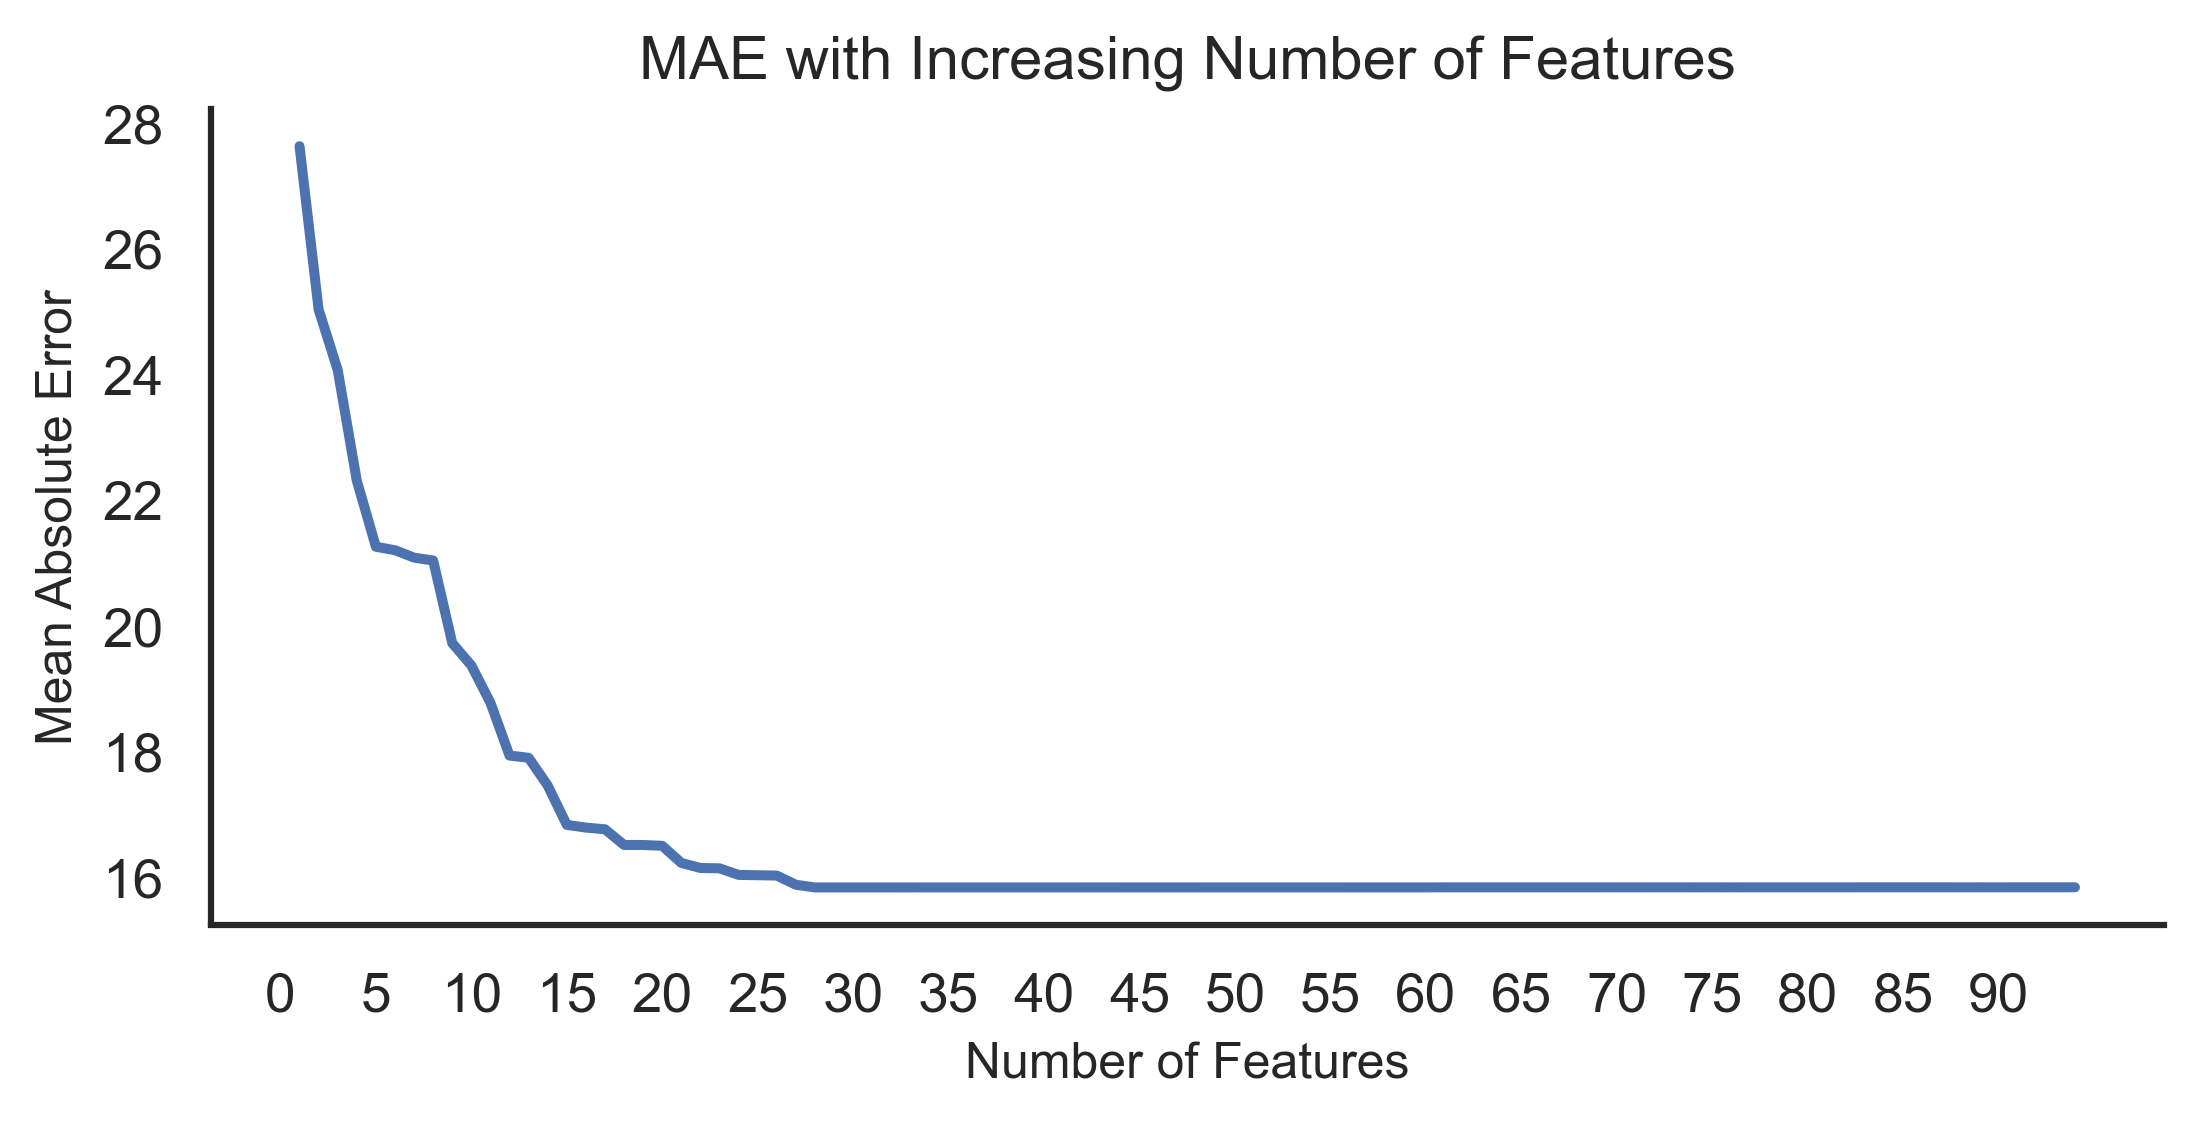

In [11]:
plt.rcParams['figure.dpi'] = 360
sns.set(style = "white")
fig, ax = plt.subplots(figsize = (7,3))
plt.plot(num_feat, mae_feat, linewidth = 2)
plt.xlabel('Number of Features', fontsize = 10)
plt.xticks(np.arange(0, max(num_feat), 5))
plt.ylabel('Mean Absolute Error', fontsize = 10)
plt.title('MAE with Increasing Number of Features', fontsize = 12)
sns.despine()
plt.savefig('LinearNumFeatures.png', bbox_inches='tight');

We can see that after the 30 best predicting features the reduction in MAE is minute. This means that we can use the top 30 features to reduce model complexity and still have a model that is as good as a model with all the features.

In [15]:
data = {'Num_feat':num_feat,
        'Mae': mae_feat,}
lin_mae = pd.DataFrame(data)
lin_mae.loc[(lin_mae['Num_feat'] > 25) & (lin_mae['Num_feat'] < 35)]

,Num_feat,Mae
25,26,16.033172
26,27,15.886813
27,28,15.844379
28,29,15.844379
29,30,15.844379
30,31,15.844366
31,32,15.844436
32,33,15.844468
33,34,15.844763


As we can see, once we get to the top 28 features MAE stays at 15.844xx. Again, meaning that using the top 28 features will predict just as well as using all the features.

### Gradient Boosting

In [16]:
gbr = make_pipeline(transformer, GradientBoostingRegressor())
mae_gbr = cross_val_score(gbr, feature_df, target, cv = 5, n_jobs = -1, scoring = 'neg_mean_absolute_error')
mean_mae_gbr = -1 * np.mean(mae_gbr)
cv_std_gbr = np.std(mae_gbr)
print(F"The 5-fold validation average MAE is {mean_mae_gbr:.5f}, and the standard deviation is {cv_std_gbr:.5f}")

The 5-fold validation average MAE is 15.65603, and the standard deviation is 0.03836


In [11]:
rand_gbr_pipe = make_pipeline(transformer, GradientBoostingRegressor())
param_grid = {
    'gradientboostingregressor__n_estimators': [50,75,100,150,200],
    'gradientboostingregressor__max_depth': [3,5,10,15,20],
    'gradientboostingregressor__learning_rate': [.01,.02,.04,.06,.08],  
}
rand_gbr = RandomizedSearchCV(rand_gbr_pipe, param_grid, cv = 2, n_iter = 10 ,n_jobs = -1, scoring='neg_mean_absolute_error')
rand_gbr.fit(feature_df, target)
rand_gbr_accuracy = rand_gbr.best_params_
rand_gbr_accuracy

KeyboardInterrupt: 